## 0. Импорт библиотек, определение функций

In [1]:
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import numpy as np
from scipy.stats import kstest, spearmanr, mannwhitneyu, levene, kruskal

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler,  PolynomialFeatures
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm

import operator

from datetime import datetime

from collections import Counter

from matplotlib.colors import ListedColormap 

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, auc, classification_report, precision_recall_curve, auc, classification_report
from sklearn.utils import shuffle


In [2]:
def get_spearman(data_1, data_2):
    correlation = spearmanr(data_1, data_2)
    return '{0:.2f}\n{1:.2f}'.format(*correlation)

In [3]:
def conf_matrix(fact, pred):
    conf_test = confusion_matrix(fact, pred, normalize='true')
    sns.heatmap(conf_test, annot=True, fmt='.2f', cmap='binary')
    plt.xlabel('Predicted', size=14)
    plt.ylabel('Actual', size=14)
    plt.show()

## 1. Импорт данных и предобработка

In [4]:
ds = pd.read_csv('data/spotify_data.csv', index_col='Unnamed: 0')
ds.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


Создание новых признаков: 
- возраст трека;
- длительность в минутах;
- популярность, как качественный показатель: если исходная популярность больше 50, то трек считается популярным.

In [5]:
ds['age'] = (datetime.today().year - ds['year']).astype('int')

In [6]:
ds['duration_min'] = ds['duration_ms']//1000//60

In [7]:
ds['popularity'] = ds['popularity'].apply(lambda x: 1 if x>=50 else 0)

Разделение признаков на группы.

In [8]:
categorial_data = ['popularity','artist_name', 'track_name', 'track_id', 'year', 'genre', 'key', 'mode','time_signature']
metric = ['danceability', 'energy', 'loudness','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min', 'age' ]

## 2. Описательные статистики

**Задание 1.** Вывести описательные статистики катеригориальных и количественных признаков. Удалить неинформативные признаки.

### 2.1 Категориальные

In [9]:
ds[categorial_data].describe()

,popularity,year,key,mode,time_signature
count,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06
mean,4.569033e-02,2.011955e+03,5.287778e+00,6.346533e-01,3.885879e+00
std,2.088127e-01,6.803901e+00,3.555197e+00,4.815275e-01,4.676967e-01
min,0.000000e+00,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.006000e+03,2.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,2.012000e+03,5.000000e+00,1.000000e+00,4.000000e+00
75%,0.000000e+00,2.018000e+03,8.000000e+00,1.000000e+00,4.000000e+00
max,1.000000e+00,2.023000e+03,1.100000e+01,1.000000e+00,5.000000e+00


In [10]:
ds[categorial_data].describe(include = 'O')

,artist_name,track_name,track_id,genre
count,1159764,1159764,1159764,1159764
unique,64159,882361,1159764,82
top,Traditional,Intro,53QF56cjZA9RTuuMZDrSA6,black-metal
freq,4058,466,1,21852


In [11]:
ds['artist_name'].nunique() # количество артистов все равно очень велико

64159

В качестве неинформативных категориальных признаков были выделены track_id, track_name и artist_name, поэтому они исключаются из дальнейшего рассмотрения

### 2.2 Количественные

In [25]:
ds[metric].describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_min,age
count,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06
mean,5.374382e-01,6.396699e-01,-8.981353e+00,9.281477e-02,3.215370e-01,2.523489e-01,2.230189e-01,4.555636e-01,1.213771e+02,3.662524e+00,1.104500e+01
std,1.844780e-01,2.705009e-01,5.682215e+00,1.268409e-01,3.549872e-01,3.650731e-01,2.010707e-01,2.685190e-01,2.977975e+01,2.507313e+00,6.803901e+00
min,0.000000e+00,0.000000e+00,-5.810000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.130000e-01,4.540000e-01,-1.082900e+01,3.710000e-02,6.400000e-03,1.050000e-06,9.790000e-02,2.260000e-01,9.879700e+01,3.000000e+00,5.000000e+00
50%,5.500000e-01,6.940000e-01,-7.450000e+00,5.070000e-02,1.470000e-01,1.760000e-03,1.340000e-01,4.380000e-01,1.219310e+02,3.000000e+00,1.100000e+01
75%,6.770000e-01,8.730000e-01,-5.276000e+00,8.900000e-02,6.400000e-01,6.140000e-01,2.920000e-01,6.740000e-01,1.399030e+02,4.000000e+00,1.700000e+01
max,9.930000e-01,1.000000e+00,6.172000e+00,9.710000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.499930e+02,1.000000e+02,2.300000e+01


## 3. Результирующий показатель

**Задание 2.** Проанализировать результирующий показатель. Определить количество наблюдений, относящихся к каждой группе. Построить круговую диаграмму, на которой отображено количество наблюдений в каждой группе и процент этих наблюдений.

In [10]:
ds['popularity'].value_counts(normalize = True)

0    0.95431
1    0.04569
Name: popularity, dtype: float64

Больше 95% наблюдений относится к первой группе

ВИЗУАЛИЗИРУЕМ

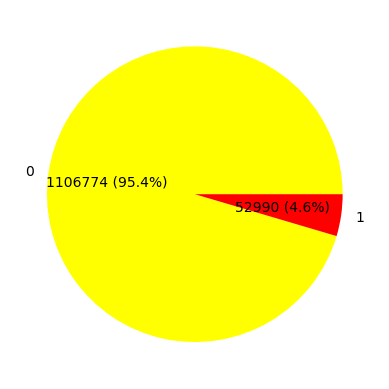

In [44]:
vc = ds['popularity'].value_counts()
plt.pie(vc, labels = vc.index, colors = ['yellow', 'red'], autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(vc)/100, p))
plt.show()

## 4. EDA

### 4.1. Рассмотрим количественные показатели

**Задание 3.** Отбор количественных показателей: 
- Определить с помощью тестов для двух независимых выборок, если ли влияние количественных показателей на результат. Сделать выводы.
- Определить с помощью корреляционной матрицы, есть ли зависимость между количественнными показателями. 
- Сдедать выводы: отобрать признаки.

In [25]:
metric

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_min',
 'age']

In [12]:
ds_0 = ds[ds['popularity'] == 0]
ds_1 = ds[ds['popularity'] == 1]

In [8]:
{i: kstest(ds_0[i].values, 'norm').pvalue for i in metric}

{'danceability': 0.0,
 'energy': 0.0,
 'loudness': 0.0,
 'speechiness': 0.0,
 'acousticness': 0.0,
 'instrumentalness': 0.0,
 'liveness': 0.0,
 'valence': 0.0,
 'tempo': 0.0,
 'duration_min': 0.0,
 'age': 0.0}

In [9]:
{i: kstest(ds_1[i].values, 'norm').pvalue for i in metric}

{'danceability': 0.0,
 'energy': 0.0,
 'loudness': 0.0,
 'speechiness': 0.0,
 'acousticness': 0.0,
 'instrumentalness': 0.0,
 'liveness': 0.0,
 'valence': 0.0,
 'tempo': 0.0,
 'duration_min': 0.0,
 'age': 0.0}

ни один из признаков не имеет нормального распределения

поэтому применяем критерий манна-уитни для сравнения медиан двух независимых выборок и критерий Левина для сравнения дисперсий

**Тест Манна-Уитни**   
Н0: медианы равны

**Тест Левина:**   
Н0: дисперсии равны

In [23]:
result = {}
for column in metric:
    groups = [ds[ds['popularity'] == i][column].values for i in ds['popularity'].unique() ]
    result[column] = [mannwhitneyu(*groups), levene(*groups, center='median'), levene(*groups, center='mean')]

In [24]:
result

{'danceability': [MannwhitneyuResult(statistic=37143344617.5, pvalue=0.0),
  LeveneResult(statistic=2398.437442475381, pvalue=0.0),
  LeveneResult(statistic=2417.0147252478323, pvalue=0.0)],
 'energy': [MannwhitneyuResult(statistic=27933540947.0, pvalue=3.705113560902627e-76),
  LeveneResult(statistic=4644.0203128417725, pvalue=0.0),
  LeveneResult(statistic=6174.160143297275, pvalue=0.0)],
 'loudness': [MannwhitneyuResult(statistic=35154726293.0, pvalue=0.0),
  LeveneResult(statistic=3013.3198284785844, pvalue=0.0),
  LeveneResult(statistic=4203.8648154278735, pvalue=0.0)],
 'speechiness': [MannwhitneyuResult(statistic=30738362177.0, pvalue=9.727261263107518e-79),
  LeveneResult(statistic=87.65309455542854, pvalue=7.813463736864858e-21),
  LeveneResult(statistic=45.740503842201484, pvalue=1.3506576415956128e-11)],
 'acousticness': [MannwhitneyuResult(statistic=30099587154.0, pvalue=6.899088333464532e-25),
  LeveneResult(statistic=3074.15930761311, pvalue=0.0),
  LeveneResult(statistic

Из всех факторов подтвердилась статистическое равенство средних и дисперсий показателя Tempo, значит его стоит исключить из доальнейшего исследования. 

У всех остальных факторов средние и дисперсии в двух группах статистически различаются

In [13]:
metric.remove('tempo')
metric

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'duration_min',
 'age']

In [10]:
correlation = ds[metric].corr(method = 'spearman')

In [11]:
table = [[get_spearman(ds[i], ds[j]) for i in metric] for j in metric]

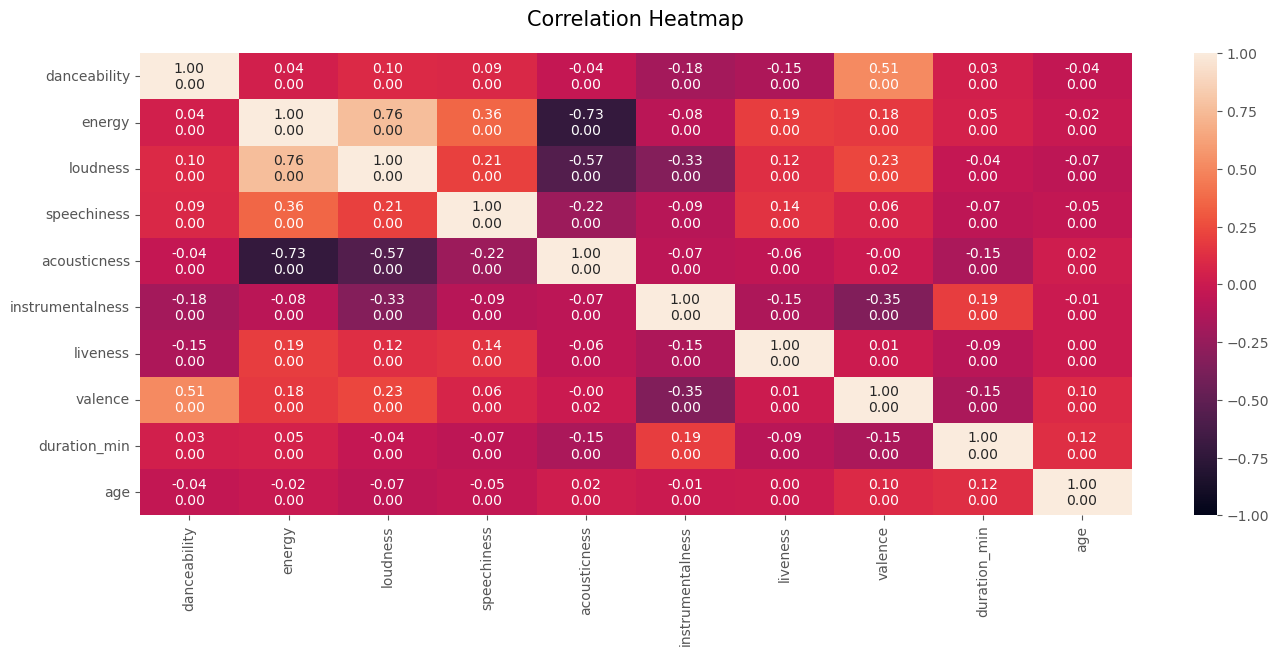

In [12]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=table, fmt='' )
heatmap.set_title('Correlation Heatmap', fontdict ={'fontsize':15}, pad=20);

Обнаружена высокая достоверная корреляция между признаками:
energy и acousticness (-0,73)   
energy и loudness (0,73)   
energy и speechiness (0,36)   
loudness и acousticness (-0,57)   
danceability и valence (0,51)   
instrumentalness и valence (-0,35)   

   Выберем age, liveness, acousticness и valence

### 4.2. Рассмотрим качественные показатели

**Задание 4.** Используя критерий согласия Пирсона определить есть ли зависимость между **качественными** признаками и результатом. Выбрать **качественные** признаки, которые влияют на результат.

In [14]:
from scipy.stats import chi2_contingency
crit_1 = 'popularity'
category = ['genre', 'key', 'mode','time_signature']

In [15]:
for crit_2 in category:
    ct = pd.crosstab(
        ds[crit_1],
        ds[crit_2])
    print( crit_2, round(chi2_contingency(ct)[1],2))

genre 0.0
key 0.0
mode 0.0
time_signature 0.0


Отвергаем нулевую гипотезу о независимости результата от каждого из факторов, т.е. каждый фактор оказывает влияние на популярность песни

## 5. Построение базовой модели

### 5.0. Модель 0

**Задание 5.** Построить модель логистической регрессии зависимости возраста песни и популярности трека. Оценить качество модели.

In [16]:
ds_y = ds['popularity']
ds_x = ds['age']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    ds_x, 
    ds_y, 
    test_size=0.2, 
    random_state=21)
X_train_1, X_test_1 = X_train.values.reshape(-1,1), X_test.values.reshape(-1,1)

In [18]:
log_reg_1 = LogisticRegression(penalty='none')
log_reg_1.fit(X_train_1, y_train)
y_approx_1 = log_reg_1.predict(X_train_1)
y_pred_1 = log_reg_1.predict(X_test_1)

log_reg_1.coef_

D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[-0.12728956]])

In [19]:
y_train.value_counts()

0    885330
1     42481
Name: popularity, dtype: int64

In [20]:
target_names = y_train.unique()

In [21]:
cm = confusion_matrix(y_test, y_pred_1, labels=log_reg_1.classes_)
pd.DataFrame(cm, index=log_reg_1.classes_, columns=log_reg_1.classes_)

,0,1
0,221444,0
1,10509,0


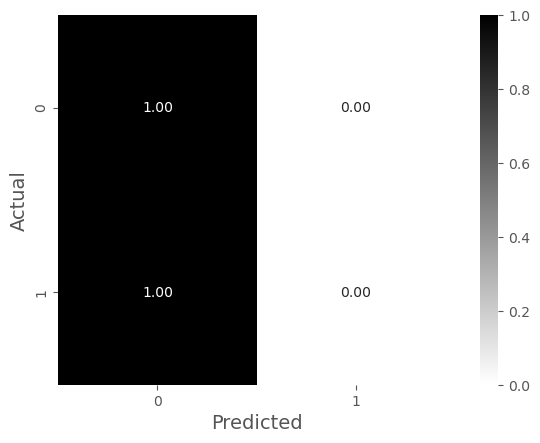

In [19]:
conf_matrix(y_test, y_pred_1)

In [22]:
print(classification_report(y_test, y_pred_1, labels=target_names))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    221444
           1       0.00      0.00      0.00     10509

    accuracy                           0.95    231953
   macro avg       0.48      0.50      0.49    231953
weighted avg       0.91      0.95      0.93    231953



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Краткий вывод:**    
ВСЕ ПЛОХО    
Модель не может предсказать 1, слишком большой дисбаланс, будем исправлять

## 5.1. Модель 1

Основная проблема, с которой вы столкнетесь -- сильный дисбаланс классов. 

Для борьбы с дисбалансом классов есть несколько методов: 
1. Взвешивание классов.
2. Уменьшение/увеличение выборки. 
3. Изменение порога классификации.

#### Взвешивание классов

Логистическая регрессия считает все объекты обучающей выборки равнозначными по умолчанию: классификация объектов класса 0 также важна, как и классификация объетов класса 1. 
В данной задаче нам важнее определить будет ли трек популярным или нет. Если важно указать, что какие-то объекты важнее, их классу присваивается вес. В алгоритме логистической регрессии библиотеке sklearn есть аргумент class_weight. По умолчанию он равен None, т. е. классы равнозначны. 
Если указать class_weight='balanced', алгоритм посчитает, во сколько раз класс «0» встречается чаще класса «1» (обозначим это число как $N$). 
- `вес класса "0":` $1.0$
- `вес класса "1":` $N$

Бóльший вес будет у редкого класса.

**Задание 6:** построить новую модель для классификации, в которой для каждого класса будет задан вес. Оценить качество полученной модели.

In [23]:
log_reg_2 = LogisticRegression(penalty='none', class_weight='balanced')
log_reg_2.fit(X_train_1, y_train)
y_approx_2 = log_reg_2.predict(X_train_1)
y_pred_2 = log_reg_2.predict(X_test_1)

log_reg_2.coef_

D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[-0.12137328]])

In [24]:
cm = confusion_matrix(y_test, y_pred_2, labels=log_reg_2.classes_)
pd.DataFrame(cm, index=log_reg_2.classes_, columns=log_reg_2.classes_)

,0,1
0,136574,84870
1,2756,7753


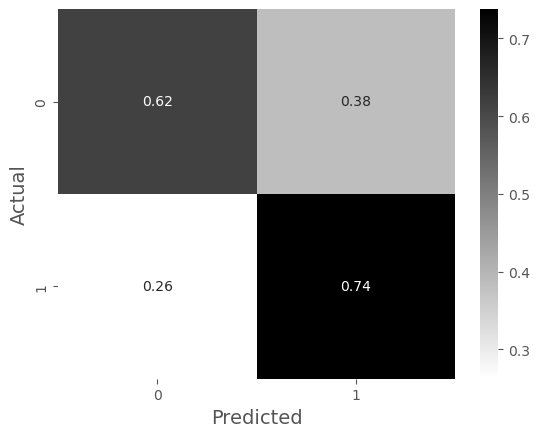

In [25]:
conf_matrix(y_test, y_pred_2)

In [26]:
print(classification_report(y_test, y_pred_2, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76    221444
           1       0.08      0.74      0.15     10509

    accuracy                           0.62    231953
   macro avg       0.53      0.68      0.45    231953
weighted avg       0.94      0.62      0.73    231953



Модель улучшилась, она научилась распознавать класс 1, но делает это достаточно плохо.    
Метрика precision для класса 1 равна 0.08, что является плохим результатом, модель слишком часто выдает 1 там, где его быть не должно.

## 5.1. Модель 2

#### Изменение размера выборки

Когда обучают модели, чтобы сбалансировать классы путём увеличения числа, такая техника называется **upsampling**.
Преобразование проходит в несколько этапов:
- Разделить обучающую выборку на объекты по классам;
- Определить тот класс, который содержит меньше объектов. Назовём его меньшим классом;
- Скопировать несколько раз объекты меньшего класса;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные.

Вместо повторения объектов меньшего класса можно убрать часть объетов большего класса. Такая процедура называется **downsampling**. Преобразование происходит в несколько этапов:

- Разделить обучающую выборку на объекты по классам;
- Определить тот класс, который содержит больше объектов. Назовём его большим классом;
- Случайным образом отбросить часть из объектов большего класса;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные.

**Задание 7:** для тренировочной данных реализуйте алгоритм уменьшения выборки. Обучите новую модель на уменьшенной выборке. Оцените качество модели на тестовой выборке. 

In [27]:
train_data = pd.concat([X_train, y_train], axis = 1)
train_data

,age,popularity
233768,7,0
167947,8,0
1289706,14,0
566665,1,0
40989,11,0
...,...,...
566392,1,0
63856,10,0
1424580,12,0
731955,23,0


In [28]:
neg_class = train_data[train_data['popularity'] == 0]
pos_class = train_data[train_data['popularity'] == 1]

In [29]:
neg_downsampled = neg_class.sample(frac=0.05, random_state = 1) 

In [30]:
downsampled_data = np.concatenate((neg_downsampled, pos_class))
downsampled_data

array([[15,  0],
       [16,  0],
       [15,  0],
       ...,
       [ 1,  1],
       [ 6,  1],
       [ 1,  1]], dtype=int64)

In [31]:
log_reg_3 = LogisticRegression(penalty='none', random_state=42)
log_reg_3.fit(downsampled_data[:, :-1], downsampled_data[:, -1])
y_approx_3 = log_reg_3.predict(downsampled_data[:, :-1])
y_pred_3 = log_reg_3.predict(X_test_1)

log_reg_3.coef_

D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[-0.12082354]])

In [32]:
cm = confusion_matrix(y_test, y_pred_3, labels=log_reg_3.classes_)
pd.DataFrame(cm, index=log_reg_3.classes_, columns=log_reg_3.classes_)

,0,1
0,136574,84870
1,2756,7753


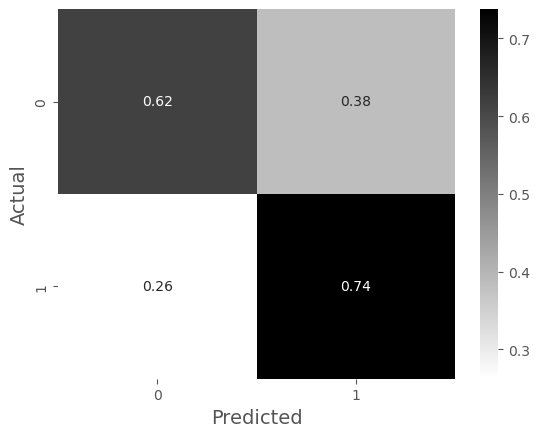

In [33]:
conf_matrix(y_test, y_pred_3)

In [34]:
print(classification_report(y_test, y_pred_3, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76    221444
           1       0.08      0.74      0.15     10509

    accuracy                           0.62    231953
   macro avg       0.53      0.68      0.45    231953
weighted avg       0.94      0.62      0.73    231953



**downsampling не повлек за собой никаких изменений, precision для единиц по-прежнему очень мал.**   
Увеличение Выборки относительно размера выборки с 1 с 0 приводит к незначительному росту precision и сильному снижению recall   
Уменьшение выборки с 0 лишь уменьшает метрику precision

## 5.1. Модель 3

#### Изменение порога классификации

Изменение порога классификации -- метод, при котором изменяется пороговое значение вероятности, согласно которому наблюдения относятся к одному из двух классов. 

Для определения оптимального порога нужно задать критерий его определения, т.к. в разных задачах присутствует своя оптимальная стратегия. Критериями выбора порога отсечения могут выступать:
1. Требование минимальной величины точности (полноты) модели. Например, нужно обеспечить точность теста не менее 80%. В этом случае оптимальным порогом будет максимальная полнота (точность), которая достигается при 80% (или значение, близкое к нему «справа» из-за дискретности ряда) точности (полноты).
2. Требование максимальной суммарной точности и полноты модели, т.е. $Cutt_off_0=max_k(precision+recall)$
3. Требование баланса между точностью и полнотой модели, т.е. $Cutt_off_0=max_k|precision-recall|$

**Задание 8.** Определить для всех построенных моделей оптимальный порог классификации. Последовательность действий для каждой модели:
1. определить множество значений порога вероятности: от 0 до 1, n значений. 
2. определить вероятности принадлежности классу для модели (использовать метод predict_proba). 
3. для каждого значения вероятности определить величины: точность, полнота, f1-мера.
4. построить на одном графике линии зависимости точности, полноты и f1-меры для заданных значений порога вероятности.
Калибровку проводить на обучающей выборке. 
На тестовой выборке оценить качество полученных моделей с учетом выбранных порогов.

In [35]:
log_reg_1.predict_proba(X_train_1)

array([[0.94450003, 0.05549997],
       [0.95080714, 0.04919286],
       [0.97646155, 0.02353845],
       ...,
       [0.96984311, 0.03015689],
       [0.99239191, 0.00760809],
       [0.95080714, 0.04919286]])

In [36]:
p_list = np.linspace(0,1,10) # 10 значений порога вероятности
precision_list = []
recall_list = []
f1_list = []
for p_value in p_list:
    y_pred_4 = [1 if i >= p_value else 0 for i in log_reg_1.predict_proba(X_train_1)[:,1]] # [:,1] - дать из списка списков только 2 значение каждого списка
    precision_list.append(precision_score(y_train, y_pred_4))
    recall_list.append(recall_score(y_train, y_pred_4))
    f1_list.append(f1_score(y_train, y_pred_4))

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

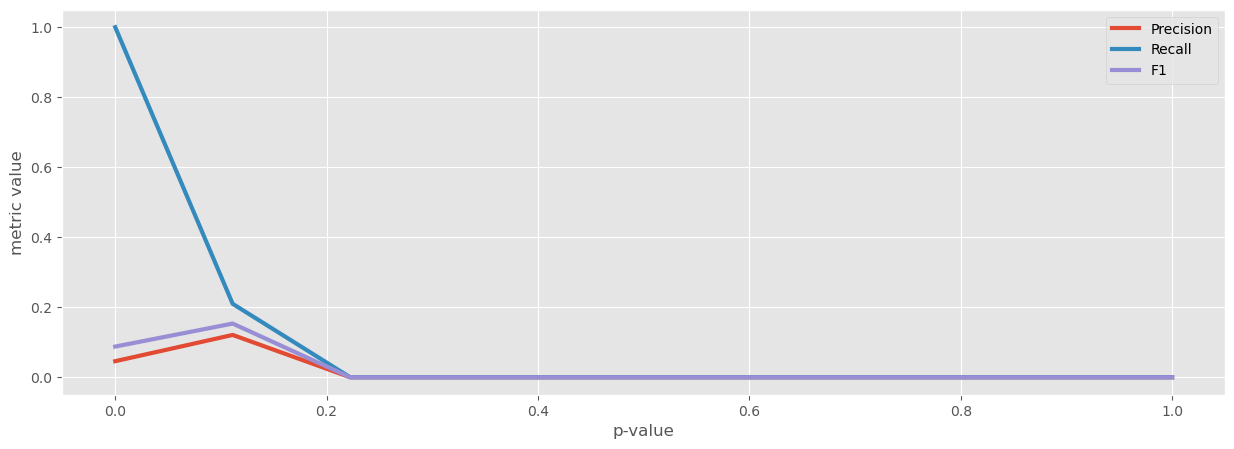

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(p_list, precision_list, linewidth = 3,label = 'Precision')
ax.plot(p_list, recall_list, linewidth = 3,label = 'Recall')
ax.plot(p_list, f1_list, linewidth = 3,label = 'F1')

plt.legend(loc = "upper right")
plt.xlabel('p-value',fontsize = 12)
plt.ylabel('metric value',fontsize = 12)
plt.show()

In [38]:
opt_loc = np.argmax(f1_list) 
opt_p =p_list[opt_loc]
opt_p

0.1111111111111111

In [39]:
y_approx_3 = [1 if i >= opt_p else 0 for i in log_reg_1.predict_proba(X_train_1)[:,1]] 
y_pred_3 =  [1 if i >= opt_p else 0 for i in log_reg_1.predict_proba(X_test_1)[:,1]]

In [40]:
cm2 = confusion_matrix(y_test, y_pred_3, labels=log_reg_1.classes_)
pd.DataFrame(cm2, index=log_reg_1.classes_, columns=log_reg_1.classes_)

,0,1
0,205072,16372
1,8284,2225


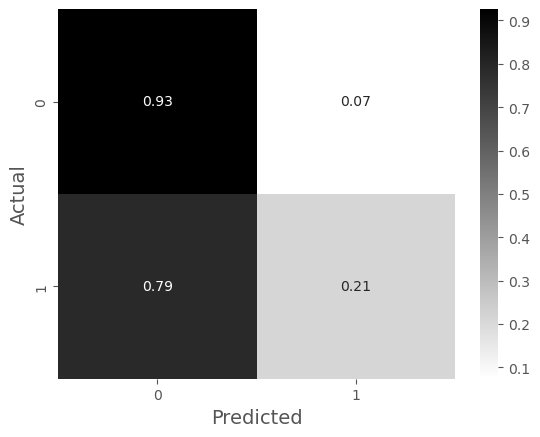

In [41]:
conf_matrix(y_test, y_pred_3)

In [42]:
print(classification_report(y_test, y_pred_3, labels=target_names))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94    221444
           1       0.12      0.21      0.15     10509

    accuracy                           0.89    231953
   macro avg       0.54      0.57      0.55    231953
weighted avg       0.92      0.89      0.91    231953



Метрика precision для целевого класса незначительно возросла, но вместе с этим recall существенно снизился. Таким образом, изменение порога классификации - неудачный способ улучшения модели

# Задание 8

**1. Оценить качество полученных в при выполнении прошлого домашнего задания моделей с помощью двух метрик:**   
     - площади кривой Precision - Recall    
     - площади под кривой ROC

Для модели 0 вычислять метрики бессмысленно, поэтому начнем с модели 1 

In [43]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

## Модель 1

### Precision-recall

In [44]:
probabilities_1 = log_reg_2.predict_proba(X_train_1)
probabilities_1

array([[0.45205994, 0.54794006],
       [0.48226298, 0.51773702],
       [0.65864503, 0.34135497],
       ...,
       [0.60217006, 0.39782994],
       [0.85190504, 0.14809496],
       [0.48226298, 0.51773702]])

In [45]:
pres_1, recall_1, treshold_1 = precision_recall_curve(y_train, probabilities_1[:,1]) # для кажд recall оценивает значения precision 
mod_1_auc = auc(recall_1, pres_1)
mod_1_auc

0.115188659070936

In [46]:
pres_rec = pd.DataFrame(precision_recall_curve(y_train, probabilities_1[:,1])).transpose()
pres_rec.columns = ['precision', 'recall', 'p-value']

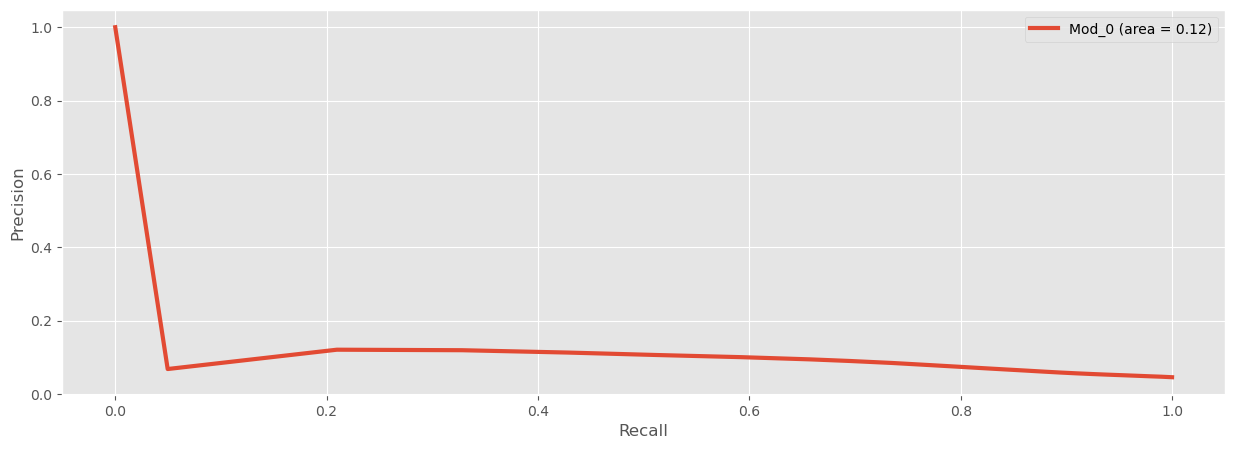

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pres_rec['recall'], pres_rec['precision'], linewidth = 3,label = 'Mod_0 (area = %0.2f)' % mod_1_auc)


plt.legend(loc = "upper right")
plt.xlabel('Recall',fontsize = 12)
plt.ylabel('Precision',fontsize = 12)
plt.show()

Площадь под кривой очень мала, модель имеет плохую прогностическую ценность

### ROC

In [48]:
roc_ds = pd.DataFrame(roc_curve(y_train, probabilities_1[:,1])).transpose()
roc_ds

,0,1,2
0,0.000000,0.000000,inf
1,0.032566,0.049622,0.739229
2,0.073231,0.209741,0.715162
3,0.116098,0.328123,0.689807
4,0.160989,0.427721,0.663257
5,0.207176,0.513359,0.635636
6,0.254365,0.592265,0.607090
7,0.302227,0.657211,0.577794
8,0.336873,0.695017,0.547940
9,0.381339,0.735034,0.517737


In [49]:
mod_1_roc_auc = auc(roc_ds[0], roc_ds[1])

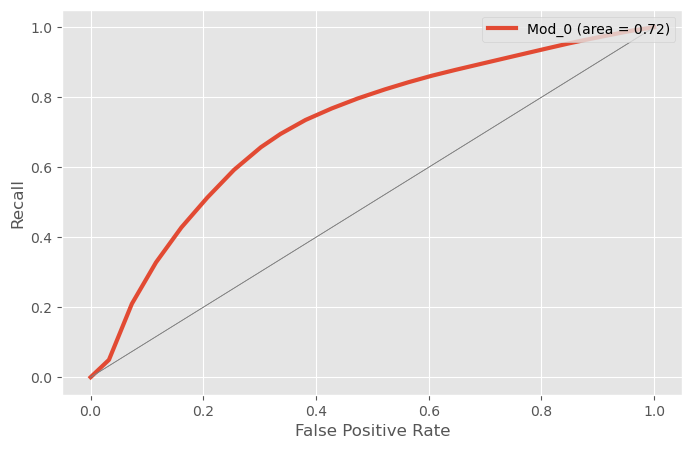

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(roc_ds[0], roc_ds[1], linewidth = 3,label = 'Mod_0 (area = %0.2f)' % mod_1_roc_auc)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12) # TPR
plt.show()

## Модель 2 

### Precision-recall

In [51]:
probabilities_2 = log_reg_3.predict_proba(downsampled_data[:, :-1])

In [52]:
pres_2, recall_2, treshold_2 = precision_recall_curve(downsampled_data[:, -1], probabilities_2[:,1])
mod_2_auc = auc(recall_2, pres_2)

In [53]:
pres_rec_1 = pd.DataFrame(precision_recall_curve(downsampled_data[:, -1], probabilities_2[:,1])).transpose()
pres_rec_1.columns = ['precision', 'recall', 'p-value'] # такое чувство, что либо здесь, либо в подписях графика precision и recall поменяны местами
pres_rec_1

,precision,recall,p-value
0,0.489711,1.000000,0.143667
1,0.497258,0.990231,0.159181
2,0.504277,0.978367,0.176025
3,0.511551,0.966385,0.194240
4,0.519315,0.953462,0.213851
5,0.527019,0.939220,0.234865
6,0.535034,0.924625,0.257268
7,0.543783,0.909395,0.281022
8,0.553296,0.893953,0.306067
9,0.564311,0.877969,0.332312


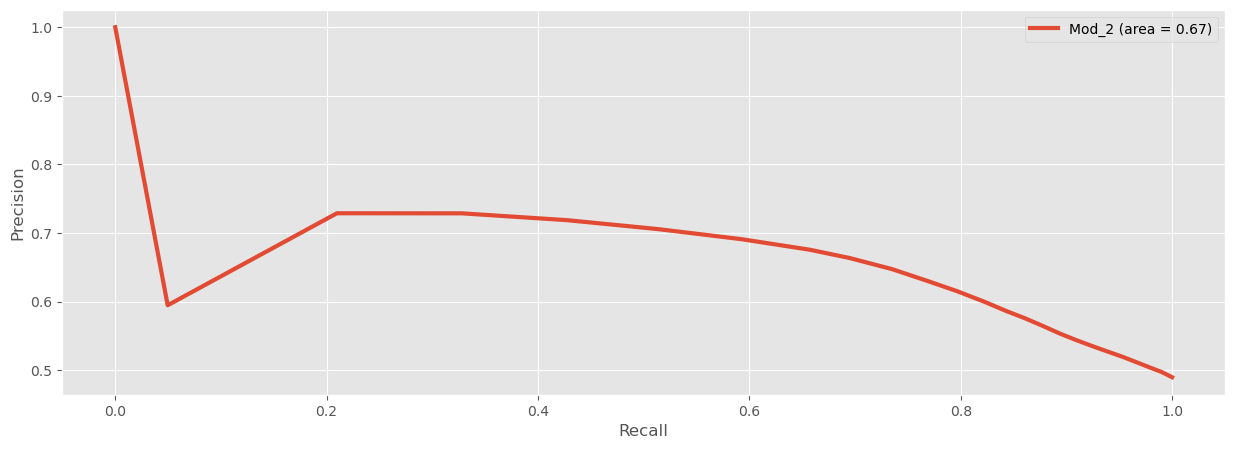

In [54]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pres_rec_1['recall'], pres_rec_1['precision'], linewidth = 3,label = 'Mod_2 (area = %0.2f)' % mod_2_auc) # чем выше 


plt.legend(loc = "upper right")
plt.xlabel('Recall',fontsize = 12)
plt.ylabel('Precision',fontsize = 12)
plt.show()

Вторая модель имеет лучшее предсказательное качество согласно метрике AUC

### ROC

In [55]:
roc_ds = pd.DataFrame(roc_curve(downsampled_data[:, -1], probabilities_2[:,1])).transpose()
mod_2_roc_auc = auc(roc_ds[0], roc_ds[1])

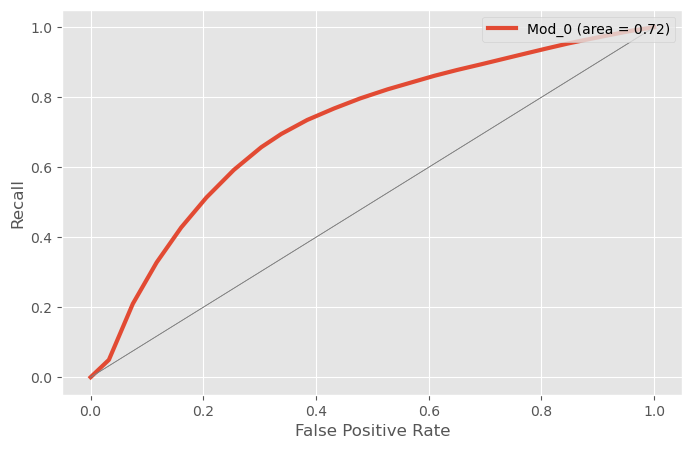

In [56]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(roc_ds[0], roc_ds[1], linewidth = 3,label = 'Mod_0 (area = %0.2f)' % mod_2_roc_auc)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12) # TPR
plt.show()

# Модель 3

### Precision-recall

In [57]:
probabilities_3 = log_reg_1.predict_proba(X_train_1)

In [58]:
pres_3, recall_3, treshold_3 = precision_recall_curve(y_train, probabilities_3[:,1])
mod_3_auc = auc(recall_3, pres_3)

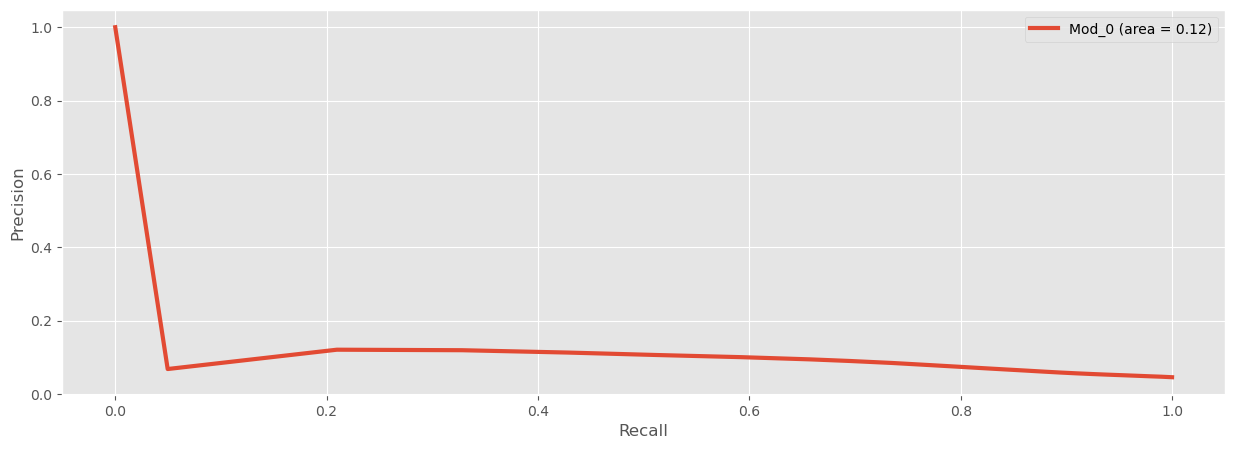

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(recall_3, pres_3, linewidth = 3,label = 'Mod_0 (area = %0.2f)' % mod_3_auc)


plt.legend(loc = "upper right")
plt.xlabel('Recall',fontsize = 12)
plt.ylabel('Precision',fontsize = 12)
plt.show()

График модели 3 совпадает с первой моделью, так как в обоих случаях мы используем одинаковую X_train

### ROC

In [60]:
roc_ds = pd.DataFrame(roc_curve(y_train, probabilities_3[:,1])).transpose()
mod_3_roc_auc = auc(roc_ds[0], roc_ds[1])

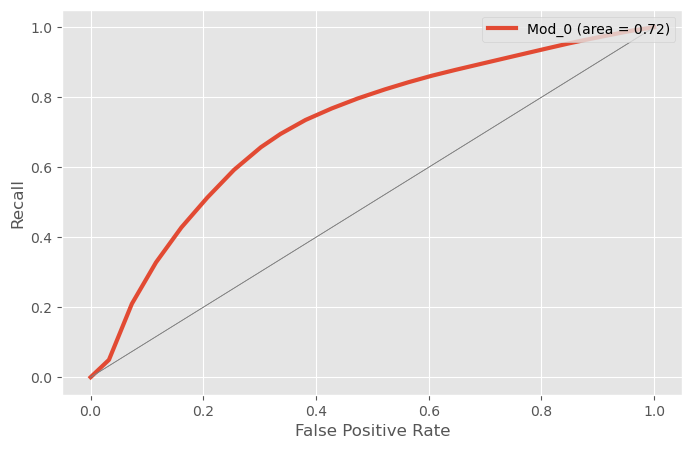

In [61]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(roc_ds[0], roc_ds[1], linewidth = 3,label = 'Mod_0 (area = %0.2f)' % mod_3_roc_auc)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12) # TPR
plt.show()

**2. Обучить новые модели логистические регрессии на всех отобранных признаках с 4 вариантами дополнительных штрафов:**   
    - none   
    - l1   
    - l2   
    - elasticnet   

In [62]:
ds_new = pd.get_dummies(ds, columns = ['mode'], drop_first = True)
ds_new

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,age,duration_min,mode_1
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,1,2012,acoustic,0.483,0.303,4,-10.058,...,0.6940,0.000000,0.1150,0.1390,133.406,240166,3,11,4,1
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,1,2012,acoustic,0.572,0.454,3,-10.286,...,0.4770,0.000014,0.0974,0.5150,140.182,216387,4,11,3,1
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,1,2012,acoustic,0.409,0.234,3,-13.711,...,0.3380,0.000050,0.0895,0.1450,139.832,158960,4,11,2,1
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,1,2012,acoustic,0.392,0.251,10,-9.845,...,0.8070,0.000000,0.0797,0.5080,204.961,304293,4,11,5,1
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,1,2012,acoustic,0.430,0.791,6,-5.419,...,0.0726,0.019300,0.1100,0.2170,171.864,244320,4,11,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473391,Nicola Conte,Black Spirits,0m27F0IGHLGAWhqd6ccYst,0,2011,trip-hop,0.373,0.742,10,-6.453,...,0.3250,0.000141,0.1590,0.5220,107.951,344013,3,12,5,0
1473392,Nicola Conte,Quiet Dawn,6er9p611eHEcUCU50j7D57,0,2011,trip-hop,0.516,0.675,7,-7.588,...,0.7880,0.000129,0.1300,0.2640,119.897,285067,4,12,4,0
1473393,Amon Tobin,Morning Ms Candis,7jsMMqxy1tt0rH5FzYcZTQ,0,2011,trip-hop,0.491,0.440,5,-8.512,...,0.4770,0.003130,0.0936,0.0351,100.076,214253,4,12,3,1
1473394,Peace Orchestra,Happy Christmas (War Is Over),77lA1InUaXztuRk2vOzD1S,0,2011,trip-hop,0.480,0.405,0,-13.343,...,0.4310,0.000063,0.1250,0.2020,133.885,239133,3,12,3,1


In [63]:
columns = ['age', 'liveness', 'acousticness' , 'valence']

In [64]:
ds_n = MinMaxScaler().fit_transform(ds_new[columns])
ds_n = pd.DataFrame(ds_n, columns=columns)

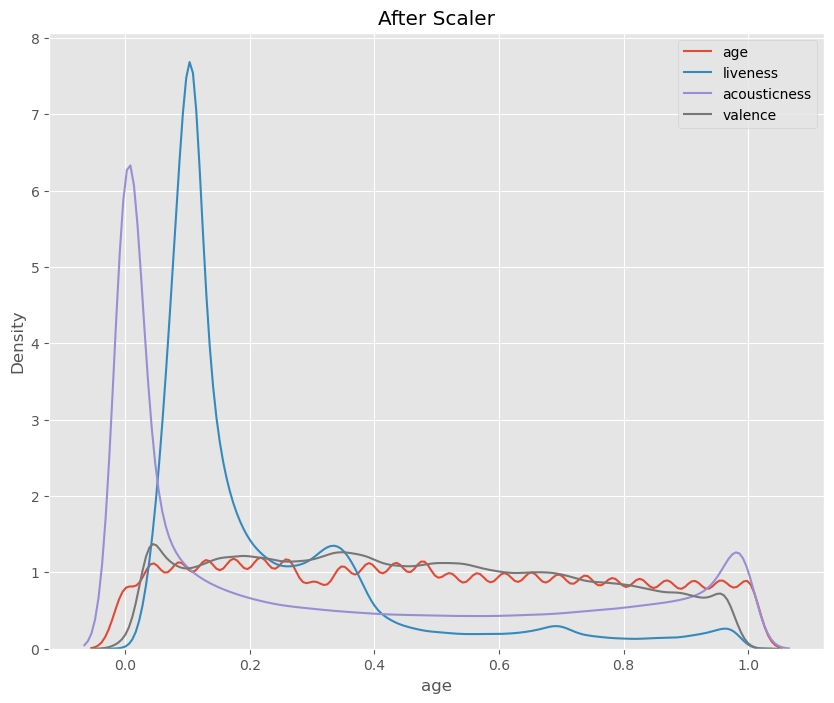

In [65]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After Scaler')

for col in columns: 
    sns.kdeplot(ds_n[col], ax=ax1, label=col )
    
ax1.legend()

In [66]:
ds_n['popularity'] = ds_new.reset_index()['popularity']
ds_n['mode'] = ds_new.reset_index()['mode_1']

In [67]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    ds_n.drop('popularity', axis=1), 
    ds_n['popularity'], 
    test_size=0.2, 
    random_state=21)

In [87]:
new_log_reg_1 = LogisticRegression(penalty='none', class_weight = 'balanced')                        #, class_weight = 'balanced'
new_log_reg_1.fit(new_X_train, new_y_train)
new_y_approx_1 = new_log_reg_1.predict(new_X_train)
new_y_pred_1 = new_log_reg_1.predict(new_X_test)
new_log_reg_1.coef_

D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[-2.85684895, -1.05427623, -0.42476485,  0.73077756, -0.05078121]])

Добавление признаков не сильно улучшило модель, поэтому оставим параметр, дающий классам веса

In [81]:
target_names = new_y_train.unique()

In [82]:
cm = confusion_matrix(new_y_test, new_y_pred_1, labels=new_log_reg_1.classes_)
pd.DataFrame(cm, index=new_log_reg_1.classes_, columns=new_log_reg_1.classes_)

,0,1
0,138382,83062
1,2744,7765


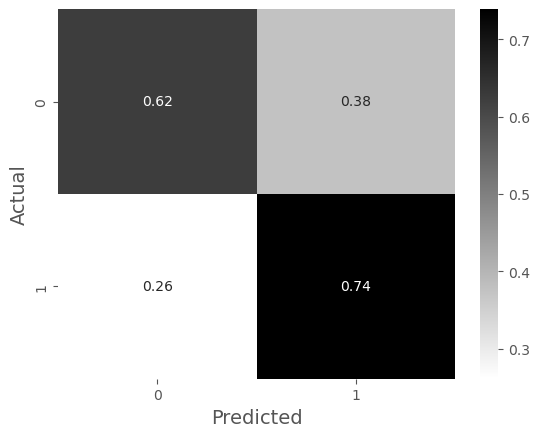

In [84]:
conf_matrix(new_y_test, new_y_pred_1)

In [85]:
print(classification_report(new_y_test, new_y_pred_3, labels=target_names))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95    221444
           1       0.13      0.21      0.16     10509

    accuracy                           0.90    231953
   macro avg       0.55      0.57      0.55    231953
weighted avg       0.92      0.90      0.91    231953



### Ridge 

In [86]:
log_reg_l2 = LogisticRegression(penalty='l2', class_weight = 'balanced')

log_reg_l2.fit(new_X_train, new_y_train)

y_approx_l2 = log_reg_l2.predict(new_X_train)
y_pred_l2 = log_reg_l2.predict(new_X_test)

log_reg_l2.coef_

array([[-2.85663639, -1.0540935 , -0.42473805,  0.73068983, -0.05078576]])

In [88]:
cm = confusion_matrix(new_y_test, y_pred_l2, labels=log_reg_l2.classes_)
pd.DataFrame(cm, index=log_reg_l2.classes_, columns=log_reg_l2.classes_)

,0,1
0,138383,83061
1,2744,7765


In [90]:
print(classification_report(new_y_test, y_pred_l2, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76    221444
           1       0.09      0.74      0.15     10509

    accuracy                           0.63    231953
   macro avg       0.53      0.68      0.46    231953
weighted avg       0.94      0.63      0.74    231953



Метрика precision для целевого признака 1 снизилась, L2 регуляризация не увенчалась успехом

### Lasso

In [102]:
log_reg_l1 = LogisticRegression(penalty='l1', class_weight = 'balanced', solver='liblinear')

log_reg_l1.fit(new_X_train, new_y_train)

y_approx_l1 = log_reg_l1.predict(new_X_train)
y_pred_l1 = log_reg_l1.predict(new_X_test)

log_reg_l1.coef_

array([[-2.85673422, -1.05405606, -0.42469952,  0.73072592, -0.05075391]])

In [101]:
cm = confusion_matrix(new_y_test, y_pred_l1, labels=log_reg_l1.classes_)
pd.DataFrame(cm, index=log_reg_l1.classes_, columns=log_reg_l1.classes_)

,0,1
0,138382,83062
1,2744,7765


In [103]:
print(classification_report(new_y_test, y_pred_l1, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76    221444
           1       0.09      0.74      0.15     10509

    accuracy                           0.63    231953
   macro avg       0.53      0.68      0.46    231953
weighted avg       0.94      0.63      0.74    231953



Лассо-регуляризация дала те же результаты

### ElasticNet

In [104]:
log_reg_el = LogisticRegression(penalty='elasticnet', class_weight = 'balanced', solver='saga', l1_ratio=0.5)

log_reg_el.fit(new_X_train, new_y_train)

y_approx_el = log_reg_el.predict(new_X_train)
y_pred_el = log_reg_el.predict(new_X_test)

log_reg_el.coef_

array([[-2.85668522, -1.0540311 , -0.42475924,  0.73062778, -0.05086629]])

In [105]:
cm = confusion_matrix(new_y_test, y_pred_el, labels=log_reg_el.classes_)
pd.DataFrame(cm, index=log_reg_el.classes_, columns=log_reg_el.classes_)

,0,1
0,138399,83045
1,2744,7765


In [106]:
print(classification_report(new_y_test, y_pred_el, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76    221444
           1       0.09      0.74      0.15     10509

    accuracy                           0.63    231953
   macro avg       0.53      0.68      0.46    231953
weighted avg       0.94      0.63      0.74    231953



Метрики для класса 1 также никак не изменились. 

Общий вывод: регуляризация не влияет на модель, это может быть связано с тем, что модель не является переобученной, в ней просто мало факторов/ факторы неподходящие

#### 3. Выбрать с помощью grid search модель (определить тип штрафа и величину штрафа), которая даст лучшее решение с точки зрения величины roc_auc.    
**Подобрать оптимальный с вашей точки зрения порог классификации.**

Валидировать параметры сложно, тк для каждого типа штрафа есть свой солвер и доп. параметры, поэтому необходимо разбирать их по отдельности 

In [135]:
from sklearn.model_selection import GridSearchCV

In [139]:
grid_space={'penalty':['l1', 'l2'],
              'C': [0.00001, 0.001, 0.01, 1, 100, 10000]}

In [140]:
grid = GridSearchCV(LogisticRegression(class_weight = 'balanced'),param_grid=grid_space,cv=3,scoring='roc_auc')
model_grid = grid.fit(new_X_train, new_y_train)

D:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

In [142]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best roc_auc is: '+str(model_grid.best_score_))

Best hyperparameters are: {'C': 0.001, 'penalty': 'l2'}
Best roc_auc is: 0.7291787168575151


GridSearch для ElasticNet (код запускается сверхдолго)

In [131]:
grid_space={'C': [0.0001, 0.01, 1, 100, 10000],
           'l1_ratio': np.linspace(0.0001,0.9999,5)}

In [132]:
grid = GridSearchCV(LogisticRegression(class_weight = 'balanced', penalty = 'elasticnet', solver = 'saga'),param_grid=grid_space,cv=3,scoring='roc_auc')
model_grid = grid.fit(new_X_train, new_y_train)

D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anacond

KeyboardInterrupt: 

In [133]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'C': 1, 'l1_ratio': 0.9}
Best score is: 0.7294721775952735
